In [1]:
import data
import data_hf
from modelling import model
import jax.numpy as jnp
import jax
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

from importlib import reload
from tqdm import tqdm
model = reload(model)
import data
import data_hf
data = reload(data)
data_hf = reload(data_hf)
import data_shae
data_shae = reload(data_shae)
import finetune
finetune = reload(finetune)
import download_data
download_data = reload(download_data)

import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from google.cloud import storage

2024-10-27 23:47:37.516195: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-27 23:47:37.524206: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-27 23:47:37.552767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-27 23:47:37.596762: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-27 23:47:37.610122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 23:47:37.642401: I tensorflow/core/platform/cpu_feature_gu

In [2]:
cfg = model.Config(
    d_model=2048,
    ffw_multiplier=4,
    query_heads=8,
    key_heads=8,
    num_layers=12,
    key_dim=128,
    vocab_size=8,
    max_seq_len=8192,
    causal=True,
    use_attn_kernel=False,
    weight_dtype_at_rest=jnp.float32,
    active_weight_dtype=jnp.bfloat16,
    rules=model.mdl_parallel_rules,
    mesh=model.create_mesh(),
    max_lr=3e-5,
    min_lr=3e-6,
    warmup_steps=50,
    total_steps=10000,
)

# Checkpoint manager setup
checkpoint_dir = "gs://minformer_data/pretrained_ckpt/v1"
ckpt_manager = model.make_mngr(path=checkpoint_dir)

In [3]:
import numpy as np
import pandas as pd
from typing import Tuple, List

def create_sequence_batch(
    df: pd.DataFrame,
    sequence_col: str,
    batch_size: int,
    max_len: int,
    tokenize_fn: callable
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Create batches of tokenized sequences with padding and segment IDs.
    
    Args:
        df: Input DataFrame containing sequences
        sequence_col: Name of column containing sequences
        batch_size: Number of sequences per batch
        max_len: Maximum length to pad sequences to
        tokenize_fn: Function to convert sequence strings to token IDs
        
    Returns:
        tuple: (tokenized_batch, segment_ids)
        - tokenized_batch: numpy array of shape (batch_size, max_len) containing token IDs
        - segment_ids: numpy array of shape (batch_size, max_len) containing 1s for valid tokens, 0s for padding
    """
    
    def process_sequence(seq: str) -> Tuple[List[int], List[int]]:
        # Tokenize and truncate if necessary
        tokens = tokenize_fn(seq[:max_len])
        # Create segment IDs (1 for real tokens, 0 for padding)
        seg_ids = [1] * len(tokens)
        # Pad both tokens and segment IDs
        padding_length = max_len - len(tokens)
        tokens.extend([0] * padding_length)
        seg_ids.extend([0] * padding_length)
        return tokens, seg_ids

    num_samples = len(df)
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_sequences = df[sequence_col].iloc[start_idx:end_idx]
        
        # Process all sequences in the batch
        batch_tokens = []
        batch_segment_ids = []
        
        for seq in batch_sequences:
            tokens, seg_ids = process_sequence(seq)
            batch_tokens.append(tokens)
            batch_segment_ids.append(seg_ids)
            
        # Convert to numpy arrays
        batch_tokens = np.array(batch_tokens)
        batch_segment_ids = np.array(batch_segment_ids)
            
        yield {'x': batch_tokens, 'segment_ids': batch_segment_ids, 'labels': np.array(df['label'].iloc[start_idx:end_idx])}

In [17]:
# We have a new thing we want to predict, so we initialise a new hidden mlp
# and a binary predictor.abs

hidden_info = model.TensorInfo(
                jax.ShapeDtypeStruct((cfg.d_model, cfg.d_model), cfg.weight_dtype_at_rest),
                ("d_model", "ffw"),
                jax.nn.initializers.he_normal(in_axis=0, out_axis=1),
            )
predictor_info = model.TensorInfo(
                jax.ShapeDtypeStruct((cfg.d_model, 2), cfg.weight_dtype_at_rest),
                ("d_model", "vocab"),
                jax.nn.initializers.he_normal(in_axis=0, out_axis=1),
            )

In [18]:
from functools import partial

def fwd(x, segment_ids, weights, hidden, predictor):
    _, internals, x = model.forward(x, segment_ids, weights, cfg)
    last_nonzero = jnp.sum(segment_ids > 0, axis=-1)
    indices = last_nonzero[:, None, None] - 1
    last_xs = jnp.take_along_axis(x, indices, 1)
    lad = jax.nn.gelu(jnp.einsum("btd,df->btf", last_xs, hidden))
    prediction = jnp.einsum("btf,fv", lad, predictor)[:, 0, :]  # [B, 2]
    return prediction, internals

def compute_loss(weights, x, segment_ids, class_target):
    weights, hidden, predictor = weights
    prediction, internals = fwd(x, segment_ids, weights, hidden, predictor)
    ce, acc = model.cross_entropy_loss(prediction, class_target, jnp.ones_like(class_target))
    internals['acc'] = acc
    internals['prediction'] = prediction
    return ce, internals

def update_step(weights, x, segment_ids, class_target, opt_state, step, cfg):
    (loss, internals), grads = jax.value_and_grad(compute_loss, has_aux=True)(weights, x, segment_ids, class_target)
    lr = model.get_lr_with_cosine_decay_and_warmup(step, cfg.total_steps, cfg.max_lr, cfg.min_lr, cfg.warmup_steps)
    weights, opt_state, internals = model.update_weights(weights, grads, opt_state, lr, step, cfg, internals)
    internals["lr"] = lr
    return loss, weights, opt_state, internals

def input_shardings(
    mesh, rules
) -> tuple[jax.sharding.NamedSharding, jax.sharding.NamedSharding, jax.sharding.NamedSharding]:
    logical_axes = {
        "x": model.P("batch", "sequence"),
        "segment_ids": model.P("batch", "sequence"),
        "labels": model.P("batch"),
    }
    physical_axes = jax.tree.map(partial(model._logical_to_sharding, mesh=mesh, rules=rules), logical_axes)
    return physical_axes


fwd = jax.jit(fwd)
compute_loss = jax.jit(compute_loss)
update_step = jax.jit(update_step, static_argnames=['cfg'])



In [19]:
storage_client = storage.Client()
bucket = storage_client.bucket('minformer_data')  # Replace with your bucket name

# List all blobs with prefix GUE/ and filter for train.csv
blobs = bucket.list_blobs(prefix='GUE/')
train_files = [blob.name for blob in blobs if blob.name.endswith('train.csv')]



In [20]:
for t in train_files:
    train = download_data.load_csv_from_gcp_bucket('minformer_data', t)
    print(t, len(train), train['sequence'].str.len().max())

GUE/EMP/H3/train.csv 11971 500
GUE/EMP/H3K14ac/train.csv 26438 500
GUE/EMP/H3K36me3/train.csv 27904 500
GUE/EMP/H3K4me1/train.csv 25341 500
GUE/EMP/H3K4me2/train.csv 24545 500
GUE/EMP/H3K4me3/train.csv 29439 500
GUE/EMP/H3K79me3/train.csv 23069 500
GUE/EMP/H3K9ac/train.csv 22224 500
GUE/EMP/H4/train.csv 11679 500
GUE/EMP/H4ac/train.csv 27275 500
GUE/mouse/0/train.csv 6478 101
GUE/mouse/1/train.csv 53952 101
GUE/mouse/2/train.csv 2620 101
GUE/mouse/3/train.csv 1904 101
GUE/mouse/4/train.csv 15064 101
GUE/prom/prom_300_all/train.csv 47356 300
GUE/prom/prom_300_notata/train.csv 42452 300
GUE/prom/prom_300_tata/train.csv 4904 300
GUE/prom/prom_core_all/train.csv 47356 70
GUE/prom/prom_core_notata/train.csv 42452 70
GUE/prom/prom_core_tata/train.csv 4904 70
GUE/splice/reconstructed/train.csv 36496 400
GUE/tf/0/train.csv 32378 101
GUE/tf/1/train.csv 30672 101
GUE/tf/2/train.csv 19000 101
GUE/tf/3/train.csv 27294 101
GUE/tf/4/train.csv 19000 101
GUE/virus/covid/train.csv 73335 999


In [25]:
import math
import dataclasses
from tqdm.notebook import tqdm

def finetune_and_report_eval(task, cfg):
    print(f'Evaluating {task}')
    train = download_data.load_csv_from_gcp_bucket('minformer_data', task)
    train_max_len = train['sequence'].str.len().max()
    num_training_examples = len(train)

    if num_training_examples > 30000:
        batch_size = 128
    elif num_training_examples > 15000:
        batch_size = 64
    else:
        batch_size = 32

    weights, opt_state = model.load(ckpt_manager, cfg)
    print('Loaded pretrained checkpoint')
    hidden = hidden_info.initializer(jax.random.PRNGKey(42), hidden_info.shape.shape, hidden_info.shape.dtype)
    predictor = predictor_info.initializer(jax.random.PRNGKey(42), predictor_info.shape.shape, predictor_info.shape.dtype)
    weights_post_surgery = (weights, hidden, predictor)
    # Assume ADAM, better to pull this directly tho.
    opt_state_post_surgery = (opt_state, (jnp.zeros_like(hidden), jnp.zeros_like(hidden)),  (jnp.zeros_like(predictor), jnp.zeros_like(predictor)))
    iterator = create_sequence_batch(train, 'sequence', batch_size=batch_size, max_len=train_max_len, tokenize_fn=data_shae.tokenize)
    finetuning_steps = math.ceil(num_training_examples / batch_size)
    print(f"Selected {batch_size} batch size for num examples {num_training_examples}, which gives {finetuning_steps} steps.")
    cfg = dataclasses.replace(
        cfg,
        total_steps=finetuning_steps
    )
    # Create tqdm progress bar with accuracy metric
    pbar = tqdm(range(finetuning_steps), desc=f'Finetuning running accuracy')
    pbar.set_postfix({
        'acc': f'{0:.4f}',
    })  # Initialize accuracy display

    for i in pbar:
        batch = next(iterator)
        batch = jax.device_put(batch, input_shardings(cfg.mesh, cfg.rules))
        _, weights_post_surgery, opt_state_post_surgery, internals = update_step(weights_post_surgery, batch['x'], batch['segment_ids'], batch['labels'], opt_state_post_surgery, i, cfg)
        pbar.set_postfix({
            'acc': f'{internals["acc"]:.4f}',
        })  # Initialize accuracy display
        
    test = download_data.load_csv_from_gcp_bucket('minformer_data', task.replace('train', 'test'))
    iterator = create_sequence_batch(test, 'sequence', batch_size=64, max_len=train_max_len, tokenize_fn=data_shae.tokenize)

    print('Fine-tuning complete, doing eval')
    accs = []
    num_examples = []
    for batch in iterator:
        batch = jax.device_put(batch, input_shardings(cfg.mesh, cfg.rules))
        _, internals = compute_loss(weights_post_surgery, batch['x'], batch['segment_ids'], batch['labels'])
        accs.append(internals['acc'])
        num_examples.append(len(batch['labels']))
    # Multiply accuracy numbers (which is a single number for the whole batch),
    # by the number of examples in that batch, so that we can divide by the 
    # total number of examples across batches . This accounts for the last
    # batch being a different number to the rest if the batch size does not
    # cleanly divide.
    numerator = np.array(accs) * np.array(num_examples)
    print(f"Final accuracy on test set: {np.sum(numerator) / np.sum(num_examples)}")

    # Clean up memory.
    print('Cleaning up memory.')
    delete_count = 0
    for array in jax.live_arrays():
        if not array.is_deleted():
            array.delete()
            delete_count += 1
    print(f"Deleted {delete_count} arrays.")
    del weights, opt_state, weights_post_surgery, opt_state_post_surgery


In [26]:
finetune_and_report_eval(train_files[0], cfg)

Evaluating GUE/EMP/H3/train.csv
Loaded pretrained checkpoint
Selected 32 batch size for num examples 11971, which gives 375 steps.


Finetuning running accuracy:   0%|          | 0/375 [00:00<?, ?it/s]

Fine-tuning complete, doing eval
Final accuracy on test set: 0.858383432817045
Cleaning up memory.
Deleted 3532 arrays.


In [27]:
for task in train_files[1:]:
    finetune_and_report_eval(task, cfg)

Evaluating GUE/EMP/H3K14ac/train.csv
Loaded pretrained checkpoint
Selected 64 batch size for num examples 26438, which gives 414 steps.


Finetuning running accuracy:   0%|          | 0/414 [00:00<?, ?it/s]

In [6]:
def get_row(cpu_batch):
    row = {
        "sequence": data_shae.detokenize(cpu_batch['x'][0]),
        "sequence_length": len(cpu_batch['x'][0]),
        
        # Use the reverse mappings
        "lad_category": data_shae.LAD_CAT_REV[int(cpu_batch['lad_category'][0][0])],
        "lad_value": float(cpu_batch['lad_value'][0][0]),
        "lad_conserved": bool(cpu_batch['lad_conserved'][0][0]),
        
        "sad_category": data_shae.SAD_CAT_REV[int(cpu_batch['sad_category'][0][0])],
        "sad_value": float(cpu_batch['sad_value'][0][0]),
        "sad_conserved": bool(cpu_batch['sad_conserved'][0]),
        
        "cell_type": data_shae.CELL_REV[int(cpu_batch['cell_type'][0][0])],
        "chromosome": cpu_batch['chromosome'][0][0].decode('utf-8'),
    }
    batch = model.process_batch_shae(cpu_batch, cfg)
    _, internals, _ = forward(batch['x'], batch['segment_ids'], weights, cfg, aux=batch['aux'])
    row['lad_pred'] = jnp.argmax(internals['lad_pred'], -1)
    row['lad_logits'] = jax.nn.softmax(internals['lad_pred'][0])
    row['sad_pred'] = jnp.argmax(internals['sad_pred'], -1)
    row['sad_logits'] = jax.nn.softmax(internals['sad_pred'][0])
    row['lad_value_pred'] = internals['lad_reg']
    row['sad_value_pred'] = internals['sad_reg']
    row['embedding'] = np.array(internals['last_embed'][0, 0, :])

    return row

In [7]:
rows = []
for i in tqdm(range(0, 10000)):
    cpu_batch = next(iter)
    cpu_row = get_row(cpu_batch)
    rows.append(cpu_row)


  0%|                                                                                                                                                                                                                                                                                                            | 0/10000 [00:00<?, ?it/s]

Found 1685 files for stage 1
Found 0 files for stage 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [30:40<00:00,  5.43it/s]


In [120]:
cpu_batch = next(iter)
batch = model.process_batch_shae(cpu_batch, cfg)
_, internals, _ = forward(batch['x'], batch['segment_ids'], weights, cfg, aux=batch['aux'])

ValueError: RESOURCE_EXHAUSTED: Error allocating device buffer: Attempting to allocate 256.00M. That was not possible. There are 69.98M free.; (0x1x0_HBM1): while running replica 0 and partition 0 of a replicated computation (other replicas may have failed as well).

In [8]:
len(rows)

10000

In [124]:
attn_scores = np.sum(np.concatenate([d['attn_scores'] for d in internals['layers']], 0), axis=(0, 1))

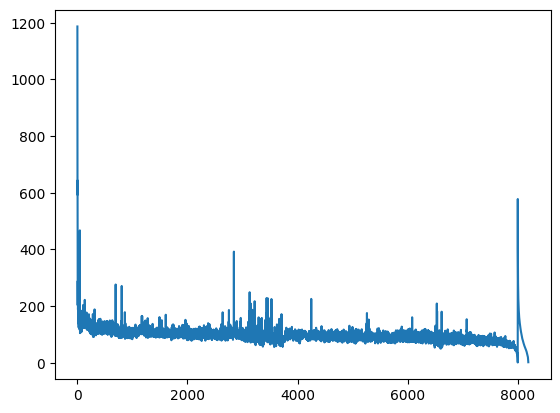

In [125]:
plt.plot(np.sum(attn_scores[:, :], axis=0))

In [61]:
cpu_row = get_row(cpu_batch)

In [62]:
cpu_row

{'sequence': 'TAAATAAGTGCCATCTTTTTGTTTTTATACTGAAAAACAAATGTATCGATTCTCAATTATTTTCTCCCTAATGTAACAATAATAACATAATATTGTATTTTCCAAAACCATTCCTCCTTTCTCTCAATTGTATGTATTTTTCCTTTTTTATTTCTCCTTTTTCTTTTTGGAGCATGATAAATATTTTTAAATCTATCCTCCTGAAATCGCATCTAGGATTTGGGATATATTTTGCCATAAATCTTTGCTTCCTTGGAATAAAAATATTCTCTACATTTTTATTATTCTAATATTGATTCAGCTTTGGAGTTAATTCATATGCAAATCAAATAATTTACCCAAACTTGTAAAGGATATGCATTATCAGAACACAACACCTGCAGGACAAAAGAGAGGTTAATTTCATTGTTGCTCCAAAGCAAAAGGAGATCATTATGGAGCCTGCAGTAACCAAGCTGTGTGAAATAGCTGCATTAGTCATTAACTTTCCAGCACTAAATTTCATATCAAACTCAATTAACTACTACATAGCTTTTAATGACAATATTTTTTCAGATGCAGCTCTTGTTTACTAATAAGATTTCACATCACGACTATCTGTTCCACTACTTCCTCCATGTTAATGAATTCAAGTCTTGATTTTCTCCAAAGAAAATGGGAAAATGAAAATCGCATTTGCTAAAATTCTCCTTGAATTATGTTTTAACATTTCAAGTGTGTTAATGTAATGCTTTAGAAGCTAAAGGGAACGATTATATAGGAAGCTAAAGTCATCTATGTCTATCCTCGGGATTGATTAAGTTTGCTATTTATACATGTTTCCCCCACAACATTGCTGTGTTGGAATTTATCAGGATAGGAACCATCTAAATTGAAAATGCCCCTTCATATATTTTTATCACAGTGAAAGTCAAAGCCTAGAATAACAAAAAGGCACAAAATTAATGTCATCAGGAAACAATTTACTCAGCTAATTAGCATAACAT

In [9]:
df = pd.DataFrame(rows)

In [10]:
df['lad_pred'] = df['lad_pred'].str[0].apply(int)

In [11]:
# Extract embeddings and compute UMAP projection
embeddings = np.stack(df['embedding'].values)
reducer = umap.UMAP(random_state=42)
umap_coords = reducer.fit_transform(embeddings)

/home/sholto/minformer/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [13]:
df.columns

Index(['sequence', 'sequence_length', 'lad_category', 'lad_value',
       'lad_conserved', 'sad_category', 'sad_value', 'sad_conserved',
       'cell_type', 'chromosome', 'lad_pred', 'lad_logits', 'sad_pred',
       'sad_logits', 'lad_value_pred', 'sad_value_pred', 'embedding'],
      dtype='object')

In [14]:
# Create plot
# plt.figure(figsize=(12, 8))
plot_df = pd.DataFrame({
    'UMAP1': umap_coords[:, 0],
    'UMAP2': umap_coords[:, 1],
    'Lad category': df['lad_category'],
    'INTER-LAD Probability': df['lad_logits'].apply(lambda x: float(x[0])),  # Extract first logit
    'lad_conserved': df['lad_conserved'],
    'Sad category': df['sad_category'],
    'INTER-SAD Probability': df['sad_logits'].apply(lambda x: float(x[0])),  # Extract first logit
    'sad_conserved': df['sad_conserved'],
    'cell_type': df['cell_type'],
    'chromosome': df['chromosome']
})

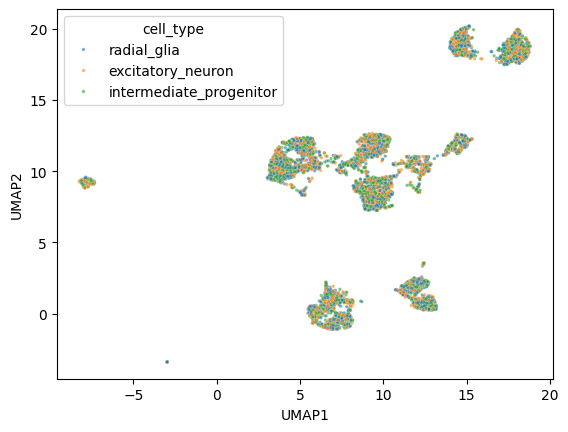

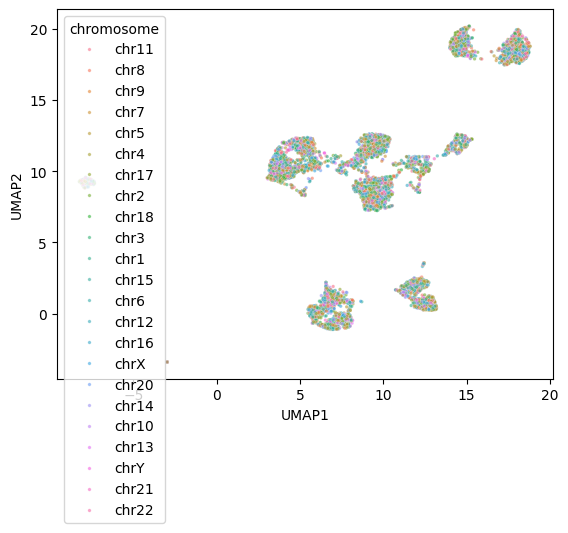

In [15]:
sns.scatterplot(data=plot_df, 
                x='UMAP1', 
                y='UMAP2', 
                hue='cell_type',
                alpha=0.6,
                s=6)
plt.show()
sns.scatterplot(data=plot_df, 
                x='UMAP1', 
                y='UMAP2', 
                hue='chromosome',
                alpha=0.6,
                s=6)
plt.show()

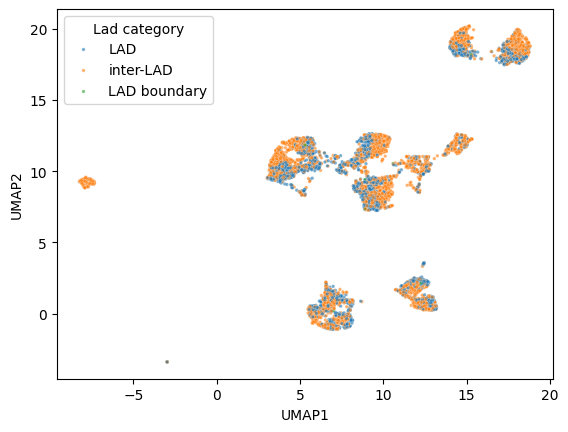

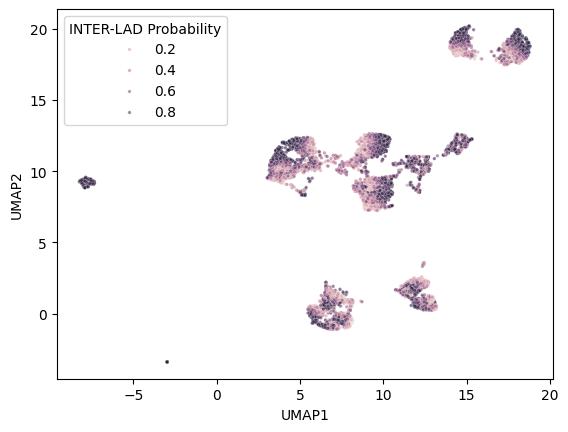

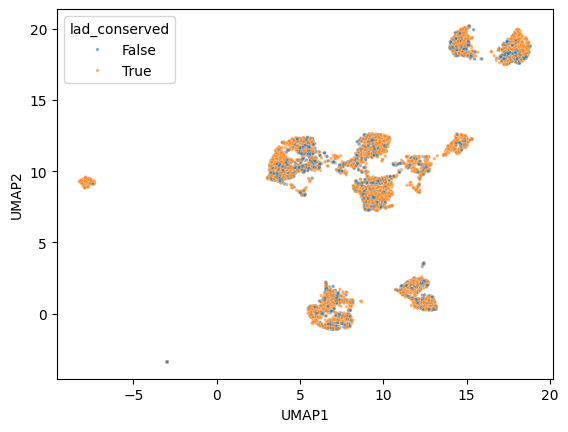

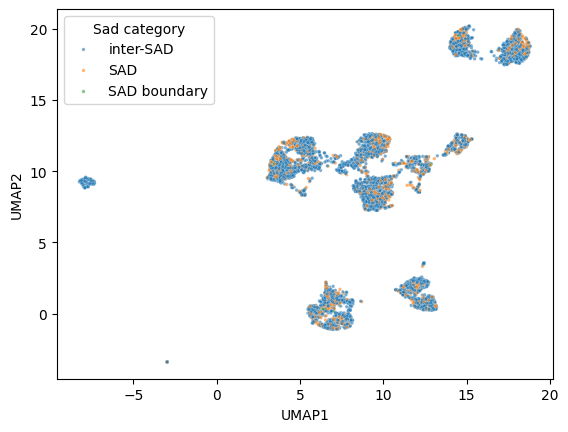

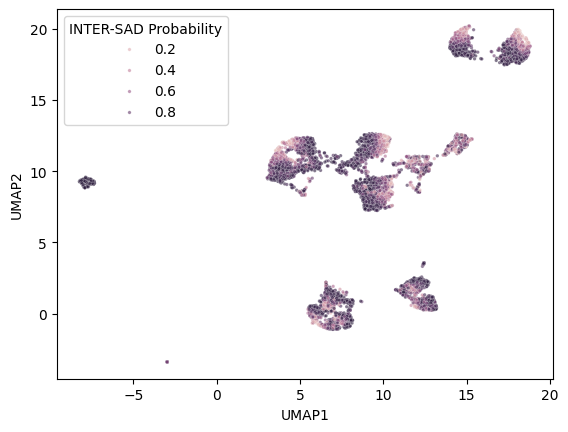

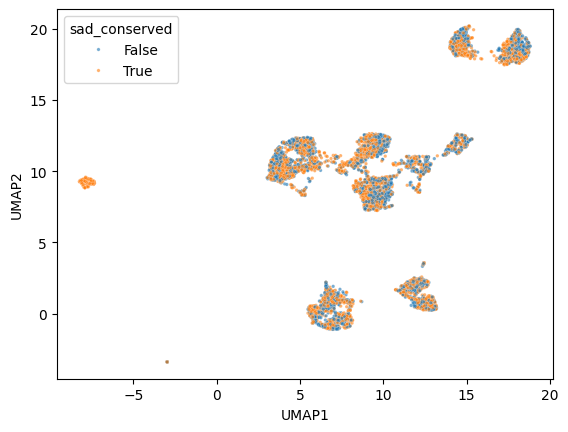

In [12]:

sns.scatterplot(data=plot_df, 
                x='UMAP1', 
                y='UMAP2', 
                hue='Lad category',
                alpha=0.6,
                s=6)
plt.show()
sns.scatterplot(data=plot_df, 
                x='UMAP1', 
                y='UMAP2', 
                hue='INTER-LAD Probability',
                alpha=0.6,
                s=6)
plt.show()
sns.scatterplot(data=plot_df, 
                x='UMAP1', 
                y='UMAP2', 
                hue='lad_conserved',
                alpha=0.6,
                s=6)
plt.show()
sns.scatterplot(data=plot_df, 
                x='UMAP1', 
                y='UMAP2', 
                hue='Sad category',
                alpha=0.6,
                s=6)
plt.show()
sns.scatterplot(data=plot_df, 
                x='UMAP1', 
                y='UMAP2', 
                hue='INTER-SAD Probability',
                alpha=0.6,
                s=6)
plt.show()
sns.scatterplot(data=plot_df, 
                x='UMAP1', 
                y='UMAP2', 
                hue='sad_conserved',
                alpha=0.6,
                s=6)
plt.show()

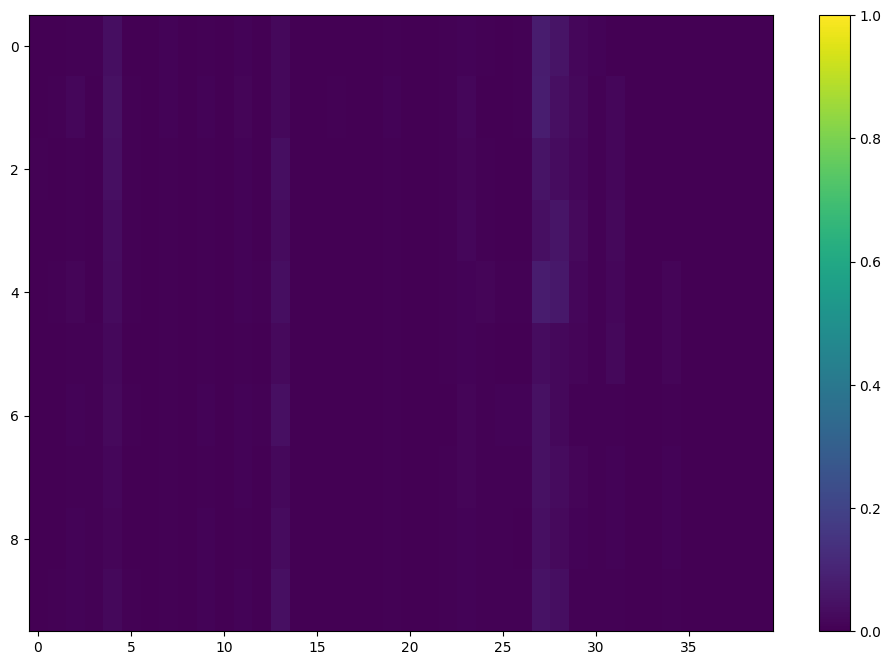

In [123]:
head_idx = 0
plt.figure(figsize=(12, 8))  # Width: 12 inches, Height: 8 inches
plt.imshow(internals['layers'][4]['attn_scores'][0, head_idx, 7990:8000, 7960:8000], 
           cmap='viridis',
           aspect='auto',
           norm=plt.Normalize(vmin=0, vmax=1))  # Normalize the color scale
plt.colorbar()  # Add a colorbar to show the scale

In [97]:
internals['layers'][4]['attn_scores'][0, 1, :, :]

Array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0.806, 0.194, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0.435, 0.263, 0.303, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0.269, 0.155, 0.369, 0.207, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0.216, 0.148, 0.293, 0.254, 0.0896, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# Lets do some data processing

In [47]:
bucket_name = "minformer_data"
intermediate_progenitor = f"eukaryote_pands/8kb_genomic_bins_with_sequences_GW17IPC.csv"
excitatory_neuron = f"eukaryote_pands/8kb_genomic_bins_with_sequences_GW17eN.csv"
radial_glia = "eukaryote_pands/8kb_genomic_bins_with_sequences_GW17RG.csv"
ip_df_base = download_data.load_csv_from_gcp_bucket(bucket_name, intermediate_progenitor)
en_df_base = download_data.load_csv_from_gcp_bucket(bucket_name, excitatory_neuron)
rg_df_base = download_data.load_csv_from_gcp_bucket(bucket_name, radial_glia)

Index(['Chrom', 'Start', 'End', 'LMNB1 Cat', 'LMNB1 Signal', 'SON Cat',
       'SON Signal', 'LMNB1 + SON', 'LMNB1 Only', 'SON Only',
       'No Nuclear-Body Association', 'Sequence'],
      dtype='object')
Index(['Chrom', 'Start', 'End', 'LMNB1 Cat', 'LMNB1 Signal', 'SON Cat',
       'SON Signal', 'LMNB1 + SON', 'LMNB1 Only', 'SON Only',
       'No Nuclear-Body Association', 'Sequence'],
      dtype='object')
Index(['Chrom', 'Start', 'End', 'LMNB1 Cat', 'LMNB1 Signal', 'SON Cat',
       'SON Signal', 'LMNB1 + SON', 'LMNB1 Only', 'SON Only',
       'No Nuclear-Body Association', 'Sequence'],
      dtype='object')


In [49]:
# Create chr19 validation set
chr19_combined = pd.concat([chr19_ip, chr19_en, chr19_rg], ignore_index=True)
chr19_combined = chr19_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Combine into single training and validation sets
train_combined = pd.concat([train_ip, train_en, train_rg], ignore_index=True)
train_combined = train_combined.sample(frac=1, random_state=42).reset_index(drop=True)
val_combined = pd.concat([val_ip, val_en, val_rg], ignore_index=True)
val_combined = val_combined.sample(frac=1, random_state=42).reset_index(drop=True)

In [66]:
data_shae.process_rows(chr19_combined, output_dir=f"gs://minformer_data/lab_data_chr19/tfrecords/", bucket=8192)

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 11033/21984 [02:50<02:49, 64.66it/s]


KeyboardInterrupt: 

In [67]:
len(train_combined)

908922

In [68]:
len(val_combined)

227229

In [28]:
# Combine all dataframes

combined_df = pd.concat([ip_df, en_df, rg_df], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate chromosome 19
chr19_df = combined_df[combined_df['Chrom'] == 'chr19'].copy()
non_chr19_df = combined_df[combined_df['Chrom'] != 'chr19'].copy()

# Split into train/test
train_df, test_df = train_test_split(non_chr19_df, test_size=0.2, random_state=42)

I1026 20:30:34.967891  752429 google_auth_provider.cc:181] Running on GCE, using service account 940527310713-compute@developer.gserviceaccount.com


In [8]:
batch = model.process_batch_shae(next(iter), cfg)

Found 2868 files for stage 1
Found 0 files for stage 2


In [8]:
import functools
step = jax.jit(model.update_step, static_argnames=["cfg", "override_compute_loss_fn"])
step = functools.partial(step, cfg=cfg, override_compute_loss_fn=finetune.compute_loss)

In [4]:
weights = model.Weights.init(cfg, jax.random.PRNGKey(0), cfg.mesh, model.fsdp_rules)
opt_state = model.init_optimizer_state(weights)

In [17]:
batch = model.process_batch_shae(next(iter), cfg, 0)
batch = jax.device_put(batch, model.input_shardings(cfg.mesh, cfg.rules))

In [18]:
batch

{'aux': {'bert_mask': Array([[ True, False, False, False, False,  True, False, False, False,  True, False, False, False, False, False, False,  True, False,  True,  True, False, False, False, False, False, False, False, False, False, False, ..., False, False,  True, False, False, False, False, False, False, False, False, False,  True, False, False, False, False, False,  True, False, False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False, False,  True, False, False, False, False,  True, False,  True, False, False, False, False, False, False, False, False,  True, False, False, ..., False, False, False, False, False,  True,  True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,  True, False, False,  True, False, False, False, False],
         [False, False, False, False,  True, False, False, False, False, False, False, False, False, False, 

In [19]:
step = jax.jit(model.update_step, static_argnames='cfg')
step = step.lower(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, 0, cfg=cfg, aux=batch['aux']).compile()

In [22]:
from jax.profiler import trace
with trace("/tmp/profile"):
    loss, weights, opt_state, internals = step(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, 0, aux=batch['aux'])
    loss, weights, opt_state, internals = step(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, 0, aux=batch['aux'])
    jax.block_until_ready(loss)

In [23]:
# Does loss go down!
for i in range(0, 10000):
    batch = model.process_batch_shae(next(iter), cfg, 0)
    batch = jax.device_put(batch, model.input_shardings(cfg.mesh, cfg.rules))
    loss, weights, opt_state, internals = step(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, i, aux=batch['aux'])
    print(i, loss, internals['accuracy'])

0 2.7370906 0.14352173
1 2.7834382 0.15569633
2 2.345886 0.19360587
3 1.9194294 0.2645749
4 1.7673976 0.2802138
5 1.7095809 0.27229536
6 1.5978522 0.28031278
7 1.5192686 0.26239732
8 1.4651344 0.26952392
9 1.4670441 0.27793726
10 1.446618 0.2783332
11 1.4317198 0.27655154
12 1.4051127 0.30723548
13 1.4085292 0.2786301
14 1.3990364 0.29892114
15 1.3873334 0.3188162
16 1.4059769 0.29318026
17 1.3847693 0.30040583
18 1.3756051 0.30832428
19 1.3670012 0.31851926
20 1.3524804 0.3305949
21 1.3665587 0.32435912
22 1.3642629 0.33079284
23 1.3697145 0.31198657
24 1.3793343 0.30218747
25 1.3655471 0.31723252
26 1.3606695 0.32623973
27 1.3684692 0.320004
28 1.3774017 0.30238545
29 1.3549788 0.3173315
30 1.362595 0.32099378
31 1.3756984 0.3158468
32 1.3714479 0.3076314
33 1.3572427 0.3178264
34 1.3637003 0.32752648
35 1.350418 0.31950906
36 1.35054 0.3387113
37 1.3542302 0.34019598
38 1.3578069 0.31752947
39 1.3670516 0.3121845
40 1.9891182 0.2986242
41 1.3529141 0.32891223
42 1.3521016 0.33099082

ValueError: One of device_put args was given the sharding of NamedSharding(mesh=Mesh('x': 8), spec=PartitionSpec('x', None)), which implies that the global size of its dimension 0 should be divisible by 8, but it is equal to 2 (full shape: (2, 8192))